# Import and misc

In [1]:
!pip install torchaudio==0.9.1 

     |████████████████████████████████| 1.9 MB 5.0 MB/s 
     |████████████████████████████████| 831.4 MB 6.7 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.


In [1]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses
import random
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [3]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    gru_dropout: float = 0.1
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [5]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2021-11-22 12:04:18--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.216.128, 2607:f8b0:400c:c12::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.216.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   135MB/s    in 10s     

2021-11-22 12:04:28 (136 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [4]:
def seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [5]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [6]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

### Augmentations

In [7]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [8]:
seed(24)
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [9]:
train_df.label.values.mean()

0.026595333745364647

In [10]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [11]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [12]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [13]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [14]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.
g = torch.Generator()
g.manual_seed(0)
train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          worker_init_fn=seed_worker,
                          generator=g,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [15]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [16]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [17]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [18]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [19]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=config.gru_dropout,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        # input: bs, n_mels, n_frames
        input = input.unsqueeze(dim=1)
        # bs x 1 x n_mels x n_frames
        conv_output = self.conv(input).transpose(-1, -2)
        # bs x L x 8 * self.conv_out_frequency
        gru_output, _ = self.gru(conv_output)
        # bs x L x hid
        contex_vector = self.attention(gru_output)
        # bs x hid
        output = self.classifier(contex_vector)
        # bs x 2
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [20]:
def train_epoch(model, opt, loader, log_melspec, device, scheduler=None):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        if scheduler is not None:
            scheduler.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [21]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [22]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [23]:
seed(24)
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
sum([p.numel() for p in model.parameters()])

70443

In [ ]:
# TRAIN
for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()


    print(f'Metric on {n}: {au_fa_fr}')
    print('END OF EPOCH', n)

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.0005444730737539649,
              0.00034473328866623963,
              0.00020153303313585224,
              0.0001397957696353575,
              9.434095970995331e-05,
              7.433177267045217e-05,
              6.633525891174909e-05,
              5.567125138428455e-05,
              5.000208118221892e-05,
              5.365123652807484e-05,
              4.750167874572892e-05,
              4.586060316092043e-05,
              3.639607269726139e-05,
              4.222636668401731e-05,
              4.403453360109719e-05,
              3.557851867864771e-05,
              4.163557947348626e-05,
              3.543529753670079e-05,
              4.9178559616024116e-05,
              2.9324528813632145e-05]})

In [ ]:
torch.save(model.state_dict(), 'baseline.pt')

In [ ]:
validation(model, val_loader, melspec_val, config.device)

102it [00:05, 18.76it/s]


2.9324528813632145e-05

# Streaming

In [ ]:
import torch.nn.functional as F


class SteamingModel(CRNN):
    def __init__(self, batch_size, config: TaskConfig):
        super().__init__(config)
        self.kernel_size = config.kernel_size[1]
        self.stride = config.stride[1]
        self.max_win_len = config.max_win_len
        self.batch_size = batch_size
        self.ptr = 0
        self.register_buffer('attn_scores', torch.zeros((self.batch_size, self.max_win_len, 1)))
        self.last_hidden = None
        self.context = None
        self.res_input = None

    def forward(self, x):
        #print('attn\n', self.attn_scores, self.ptr)

        if self.res_input is not None:
            x = torch.cat([self.res_input, x], dim=2)
            # print('Res:', self.res_input.shape, 'Inp:', x.shape)

        if x.size(2) < self.kernel_size:
            x = F.pad(x, (0, self.kernel_size - x.size(2)))

        conv_output_size = self.calc_conv_output_size(x.size(2))
        used_size = self.calc_used_size(conv_output_size)
        #print('Out:', conv_output_size, 'Used:', used_size)

        self.res_input = x[:, :, used_size:]
        x = x.unsqueeze(dim=1)

        # bs x conv_output_size x 8 * cof
        conv_output = self.conv(x).transpose(-1, -2)
        upd_size = min(conv_output_size, self.max_win_len - self.ptr)

        #print('upd', upd_size, 'cot:', conv_output_size)
        gru_output, self.last_hidden = self.gru(conv_output, self.last_hidden)
        attn_scores = self.attention.energy(gru_output).exp()
        self.attn_scores[:, self.ptr:self.ptr+upd_size] = attn_scores[:, :upd_size]
        self.ptr += upd_size

        if self.context is None:
            self.context = (gru_output * attn_scores).sum(dim=1)
        else:
            new_context = (gru_output[:, :upd_size] * attn_scores[:, :upd_size]).sum(dim=1)
            self.context = self.context + new_context

        norm_constant = self.attn_scores[:, :self.ptr].sum()
        logits = self.classifier(self.context / norm_constant)

        if self.ptr == self.max_win_len:
            self.reset(True)

            if upd_size < conv_output_size:
                self.attn_scores[:, :conv_output_size - upd_size] = attn_scores[:, upd_size:]
                self.context = (gru_output[:, upd_size:] * attn_scores[:, upd_size:]).sum(dim=1)
                self.ptr = conv_output_size - upd_size
        
        return logits

    def reset(self, reset_hidden=True):
        self.register_buffer('attn_scores', torch.zeros((self.batch_size, self.max_win_len, 1)))
        if reset_hidden:
            self.last_hidden = None
        self.context = None
        self.res_input = None
        self.ptr = 0


    def calc_conv_output_size(self, input_size):
        return (input_size - self.kernel_size) // self.stride + 1

    def calc_used_size(self, output_size):
        return (output_size - 1) * self.stride + self.kernel_size


In [ ]:
@dataclasses.dataclass
class StreamingConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    max_win_len: int = 11
    hidden_size: int = 64
    gru_num_layers: int = 2
    gru_dropout: float = 0.1
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = SteamingModel(1, StreamingConfig()).to(StreamingConfig.device)
model.load_state_dict(torch.load('baseline.pt'), strict=False)

_IncompatibleKeys(missing_keys=['attn_scores'], unexpected_keys=[])

In [ ]:
batch = next(iter(val_loader))

In [ ]:
pos_index = torch.where(batch[1] == 1)[0]
neg_index = torch.where(batch[1] == 0)[0]

x = torch.cat([batch[0][neg_index[30:40]].view(-1), batch[0][pos_index[0]], batch[0][neg_index[40:50]].view(-1)], dim=0).unsqueeze(0)
x = melspec_val(x.to(StreamingConfig.device))

In [ ]:
model.eval()
model.reset()
probs = []
step_size = 20
with torch.no_grad():
    for i in range(0, x.size(2), step_size):
        logits = model(x[:, :, i:i+step_size])
        probs.append(F.softmax(logits, dim=1)[0, 1].item())

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [ ]:
import matplotlib.pyplot as plt

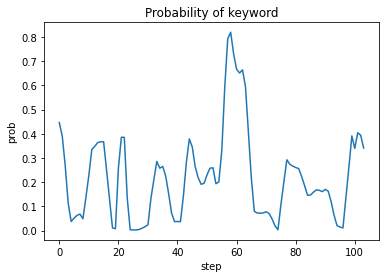

In [ ]:
smoothed_probs = moving_average(probs, 3)
plt.title('Probability of keyword')
plt.xlabel('step')
plt.ylabel('prob')
plt.plot(np.arange(len(smoothed_probs)), smoothed_probs)
plt.show()

## Optimizing

In [25]:
!pip install thop

In [23]:
@dataclasses.dataclass
class TaskConfigCpu:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    gru_dropout: float = 0.1
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = 'cpu'

In [24]:
from thop import profile
from os.path import getsize
from os import remove

BASELINE_MACS = 119527424
BASELINE_SIZE = 0.27299976348876953
BASELINE_METRIC = 5e-5

def get_size_in_megabytes(model):
    torch.save(model.state_dict(), 'temp.p')
    size = getsize('temp.p') / 2**20
    remove('temp.p')
    return size

def get_report(model):
    melspec_val = LogMelspec(is_train=False, config=TaskConfigCpu)
    au_fa_fr = validation(model, val_loader,
                              melspec_val, 'cpu')
    size = get_size_in_megabytes(model)
    inp = torch.randn(128, 40, 101)
    macs, flops = profile(model, (inp,))
    
    print('AU_fa_fr:', au_fa_fr)
    print('Size:', size)
    print('MACS, FLOPS:', macs, flops)

    print('Metric ratio (baseline/model):', BASELINE_METRIC / au_fa_fr)
    print('Size ratio (baseline/model):', BASELINE_SIZE / size)
    print('MACs ratio (baseline/model):', BASELINE_MACS / macs)

    return au_fa_fr, size, macs, flops

In [25]:
config = TaskConfig()
model = CRNN(config).to(config.device)
model.load_state_dict(torch.load('baseline.pt'))

<All keys matched successfully>

In [26]:
baseline_auc, baseline_size, baseline_macs, baseline_flops = get_report(model.cpu())

102it [00:09, 10.39it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
AU_fa_fr: 2.9324528813632145e-05
Size: 0.27299976348876953
MACS, FLOPS: 119527424.0 70443.0
Metric ratio (baseline/model): 1.7050572344322346
Size ratio (baseline/model): 1.0
MACs ratio (baseline/model): 1.0


Но всё равно используем бейзлайн 5e-5 из условия.

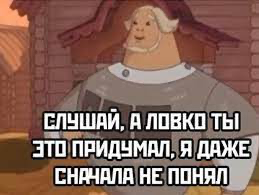

## Quantilization

In [64]:
quantized_model = torch.quantization.quantize_dynamic(
    model.cpu(), {nn.GRU, nn.Linear}, dtype=torch.qint8
)

In [ ]:
quantized_auc, quantized_size, quantized_macs, quantized_flops = get_report(quantized_model)

102it [00:09, 10.74it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>

MACs при квантизации считается неправильно, так что смотрим только на размер и метрику.

# Pruning

In [ ]:
import torch.nn.utils.prune as prune

In [ ]:
def iterative_pruning(model, opt, scheduler, melspec_train, train_loader, config):

    prune_rate_per_epoch = 1 - (1 - config.prune_rate)**(1/config.num_epochs)
    for n in range(config.num_epochs):
        prune.l1_unstructured(model.gru, name='weight_hh_l1', amount=prune_rate_per_epoch)
        prune.l1_unstructured(model.gru, name='weight_ih_l1', amount=prune_rate_per_epoch)
        prune.l1_unstructured(model.gru, name='bias_hh_l1', amount=prune_rate_per_epoch)
        prune.l1_unstructured(model.gru, name='bias_ih_l1', amount=prune_rate_per_epoch)
        model.train()
        # train_epoch(model, opt, train_loader, melspec_train, config.device)
        for i, (batch, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            batch, labels = batch.to(config.device), labels.to(config.device)
            batch = melspec_train(batch)

            opt.zero_grad()

            # run model # with autocast():
            logits = model(batch)
            # we need probabilities so we use softmax & CE separately
            probs = F.softmax(logits, dim=-1)
            loss = F.cross_entropy(logits, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

            opt.step()

            if scheduler is not None:
                scheduler.step()

            # logging
            argmax_probs = torch.argmax(probs, dim=-1)
            FA, FR = count_FA_FR(argmax_probs, labels)
            acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

        au_fa_fr = validation(model, val_loader,
                            melspec_val, config.device)
        history['val_metric'].append(au_fa_fr)

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

        print('END OF EPOCH', n)

In [ ]:
@dataclasses.dataclass
class PruningConfig:
    keyword: str = 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 25
    n_mels: int = 40
    cnn_out_channels: int = 3
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    prune_rate: float = 0.999999
    gru_num_layers: int = 2
    gru_dropout: float = 0
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
seed(24)
history = defaultdict(list)
config = PruningConfig()
model = CRNN(config).to(config.device)
# model.load_state_dict(torch.load('/content/drive/My Drive/dla_hw2/baseline.pt'))
opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

In [ ]:
iterative_pruning(model, opt, None, melspec_train, train_loader, config)

In [ ]:
get_report(model.cpu())

In [ ]:
state = model.state_dict()
del state['gru.weight_hh_l1']
del state['gru.weight_ih_l1']
del state['gru.bias_hh_l1']
del state['gru.bias_ih_l1']

In [ ]:
torch.save(state, 'pruned.pt')

In [ ]:
@dataclasses.dataclass
class PrunedConfig:
    keyword: str = 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 25
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    prune_rate: float = 0.99
    gru_num_layers: int = 1
    gru_dropout: float = 0
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
config = PrunedConfig()
model = CRNN(config).to(config.device)

In [ ]:
model.load_state_dict(torch.load('pruned.pt'))

<All keys matched successfully>

In [ ]:
get_report(model.cpu())

102it [00:09, 10.75it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
AU_fa_fr: 0.01316755486152977
Size: 0.1768198013305664
MACS, FLOPS: 83752960.0 45483.0


(0.01316755486152977, 0.1768198013305664, 83752960.0, 45483.0)

# Distillation

In [40]:
def distil_loss(t_logits, s_logits, labels, temperature, alpha):
    t_probs = F.softmax(t_logits / temperature, dim=1)
    s_logprobs = F.log_softmax(s_logits / temperature, dim=1)
    distil_reg = temperature**2 * -(t_probs * s_logprobs).sum(dim=1).mean() # F.kl_div(s_logprobs, t_probs, reduction='batchmean')
    student_loss = F.cross_entropy(s_logits, labels)

    return alpha * distil_reg + (1 - alpha) * student_loss


def train_with_teacher(teacher, student, opt, temperature, alpha,
                       loader, log_melspec, device):
    teacher.eval()
    student.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        with torch.no_grad():
            t_logits = teacher(batch)

        s_logits = student(batch)
        loss = distil_loss(t_logits, s_logits, labels, temperature, alpha)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        opt.step()
        # logging
        argmax_probs = torch.argmax(s_logits, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [56]:
@dataclasses.dataclass
class StudentConfig:
    keyword: str = 'sheila'
    batch_size: int = 128
    learning_rate: float = 1e-3
    weight_decay: float = 1e-7
    num_epochs: int = 25
    n_mels: int = 40
    cnn_out_channels: int = 3
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 14)
    hidden_size: int = 32
    gru_num_layers: int = 1
    gru_dropout: float = 0
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [57]:
seed(42)
history = defaultdict(list)
teacher_config = TaskConfig()
teacher = CRNN(teacher_config).to(teacher_config.device)
teacher.load_state_dict(torch.load('baseline.pt'))

student_config = StudentConfig()
student = CRNN(student_config).to(student_config.device)
opt = torch.optim.Adam(
    student.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, student_config.num_epochs)

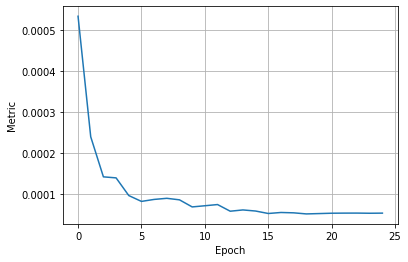

END OF EPOCH 24


In [58]:
for n in range(student_config.num_epochs):

    train_with_teacher(teacher, student, opt, 5, 0.8, train_loader, melspec_train, student_config.device)
    scheduler.step()
    au_fa_fr = validation(student, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [60]:
torch.save(student.state_dict(), 'distillated.pt')

In [141]:
student_auc, student_size, student_macs, student_flops = get_report(student.cpu())

102it [00:08, 11.40it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
AU_fa_fr: 5.334390782764708e-05
Size: 0.04452228546142578
MACS, FLOPS: 11667968.0 9906.0
Metric ratio (baseline/model): 0.9373141570645487
Size ratio (baseline/model): 6.131755381814287
MACs ratio (baseline/model): 10.244065119136426


In [142]:
quantized_student = torch.quantization.quantize_dynamic(
    student.cpu(), {nn.GRU, nn.Linear}, dtype=torch.qint8
)

In [143]:
qstudent_auc, qstudent_size, qstudent_macs, qstudent_flops = get_report(quantized_student.cpu())

102it [00:08, 11.56it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>

MACs при квантизации считается неправильно, так что опять же смотрим только на размер и метрику

# Результаты

In [144]:
baseline_auc, baseline_size, baseline_macs, baseline_flops = get_report(model.cpu())
quantized_auc, quantized_size, quantized_macs, quantized_flops = get_report(quantized_model)
student_auc, student_size, student_macs, student_flops = get_report(student.cpu())

102it [00:09, 10.99it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
AU_fa_fr: 2.9324528813632145e-05
Size: 0.2764444351196289
MACS, FLOPS: 119527424.0 70443.0
Metric ratio (baseline/model): 1.7050572344322346
Size ratio (baseline/model): 0.9875393706899228
MACs ratio (baseline/model): 1.0


102it [00:09, 10.88it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>

102it [00:08, 11.58it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
AU_fa_fr: 5.334390782764708e-05
Size: 0.04452228546142578
MACS, FLOPS: 11667968.0 9906.0
Metric ratio (baseline/model): 0.9373141570645487
Size ratio (baseline/model): 6.131755381814287
MACs ratio (baseline/model): 10.244065119136426


In [146]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

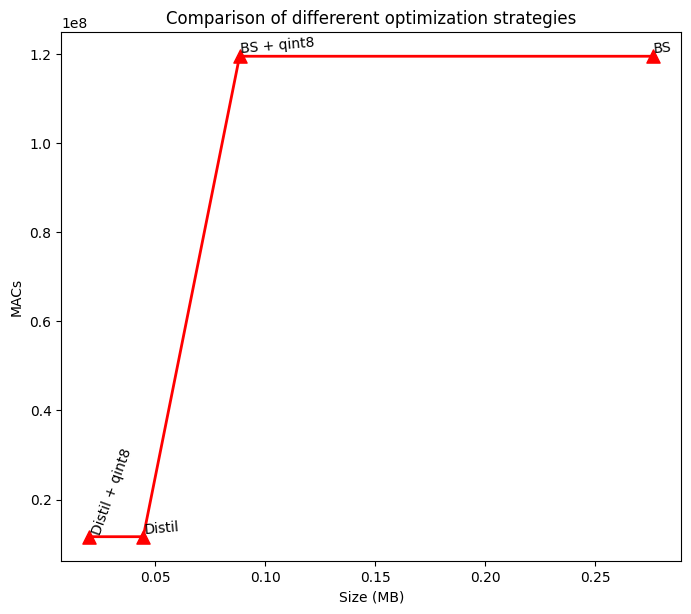

In [147]:
# baseline, quantized_baseline, distillated_student, quantized_distillated_student
macs = [baseline_macs, baseline_macs, student_macs, student_macs] 
sizes = [baseline_size, quantized_size, student_size, qstudent_size]
labels = ['BS', 'BS + qint8', 'Distil', 'Distil + qint8']
rotations = [5, 5, 5, 70]
fig = plt.figure(figsize=(8, 7), dpi=100)
ax = plt.gca()

ax.scatter(sizes, macs, marker='^', s=90, color='red')
ax.plot(sizes, macs, linewidth=2, color='red')
ax.set_xlabel('Size (MB)')
ax.set_ylabel('MACs')
ax.set_title('Comparison of differerent optimization strategies')
for i, (label, angle) in enumerate(zip(labels, rotations)):
    t = ax.annotate(label, (sizes[i], macs[i]), horizontalalignment='left',
                       verticalalignment='bottom')
    t.set_rotation(angle)
plt.savefig('fig.png', dpi=130)
plt.show()
